In [8]:
from pyspark.sql import SparkSession

# Định nghĩa constants
HDFS_HOST = "hdfs://localhost:9000"  
HDFS_PATH = f"{HDFS_HOST}/hadoop/data/parquet/"

def create_spark_session(app_name="IMDb Analytics"):
    """
    Tạo và cấu hình SparkSession với các thiết lập phù hợp.
    
    Parameters:
        app_name (str): Tên của ứng dụng Spark
        
    Returns:
        SparkSession: SparkSession đã được cấu hình
    """
    return SparkSession.builder \
        .appName(app_name) \
        .master("spark://localhost:7077") \
        .config("spark.executor.memory", "2g") \
        .config("spark.hadoop.fs.defaultFS", HDFS_HOST) \
        .config("spark.sql.warehouse.dir", f"{HDFS_HOST}/user/hive/warehouse") \
        .config("spark.executor.cores", "1") \
        .config("spark.sql.files.maxPartitionBytes", "128MB") \
        .config("spark.sql.shuffle.partitions", "4") \
        .config("spark.executor.instances", "2")  \
        .getOrCreate()
       

# Hàm tiện ích để kiểm tra kết nối HDFS
def test_hdfs_connection(spark):
    """
    Kiểm tra kết nối tới HDFS bằng cách đọc thử một file parquet
    
    Parameters:
        spark (SparkSession): SparkSession đã được khởi tạo
        
    Returns:
        bool: True nếu kết nối thành công, False nếu thất bại
    """
    try:
        # Thử đọc một file parquet bất kỳ
        test_df = spark.read.parquet(f"{HDFS_PATH}/title_basics_parquet")
        test_df.printSchema()
        return True
    except Exception as e:
        print(f"Lỗi kết nối HDFS: {str(e)}")
        return False

In [10]:
# When have 2 workers
spark = create_spark_session()

# Sử dụng SparkContext để lấy thông tin về các executors
workers_info = spark.sparkContext._jsc.sc().statusTracker().getExecutorInfos()

# Đếm số lượng workers (executors)
num_workers = len(workers_info) - 1

# In ra số lượng workers và thông tin chi tiết
print(f"Số lượng workers đang hoạt động: {num_workers}")
for worker in workers_info:
    print(f"Executor Info: {worker}")


Số lượng workers đang hoạt động: 0
Executor Info: org.apache.spark.SparkExecutorInfoImpl@135e7890


In [19]:
from pyspark.sql import SparkSession
import time
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.utils import AnalysisException
import subprocess
# Danh sách các file cần test
files = [
    'name.basics',
    'title.akas',
    'title.basics',
    'title.crew',
    'title.episode',
    'title.principals',
    'title.ratings'
]
def get_file_size(hdfs_path):
    """Lấy kích thước file/thư mục từ HDFS"""
    try:
        # Với file TSV.GZ
        if hdfs_path.endswith('.tsv.gz'):
            cmd = f"hdfs dfs -ls {hdfs_path} | awk '{{print $5}}'"
            size = int(subprocess.check_output(cmd, shell=True).decode().strip())
            return size
        # Với thư mục Parquet
        else:
            cmd = f"hdfs dfs -du -s {hdfs_path} | awk '{{print $1}}'"
            size = int(subprocess.check_output(cmd, shell=True).decode().strip())
            return size
    except subprocess.CalledProcessError:
        print(f"Không thể lấy kích thước của {hdfs_path}")
        return None

def format_size(size_in_bytes):
    """Chuyển đổi kích thước từ bytes sang MB/GB"""
    if size_in_bytes is None:
        return "N/A"
    mb = size_in_bytes / (1024 * 1024)
    if mb > 1024:
        return f"{mb/1024:.2f} GB"
    return f"{mb:.2f} MB"

def measure_reading_time(spark, file_path, format_type):
    try:
        print(f"Đang thử đọc file: {file_path}")
        start_time = time.time()
        
        if format_type == 'tsv':
            df = spark.read.csv(file_path, sep='\t', header=True)
        else:
            df = spark.read.parquet(file_path)
            
        # Force computation through count action
        count = df.count()
        end_time = time.time()
        print(f"Đọc thành công: {count} dòng")
        return end_time - start_time, count
    except Exception as e:
        print(f"Lỗi khi đọc file: {str(e)}")
        return None, None

def read_speed_files(files):
    results = []
    for file_name in files:
        tsv_path = f'/hadoop/data/{file_name}.tsv.gz'
        # Sửa lại tên thư mục Parquet để khớp với cấu trúc thực tế
        parquet_path = f'/hadoop/data/parquet/{file_name.replace(".", "_")}_parquet'
        
        print(f"\nĐang xử lý: {file_name}")
        
        # Lấy kích thước file
        tsv_size = get_file_size(tsv_path)
        parquet_size = get_file_size(parquet_path)
        
        print(f"Kích thước TSV.GZ: {format_size(tsv_size)}")
        print(f"Kích thước Parquet: {format_size(parquet_size)}")
        
        # Chỉ thêm vào results nếu cả hai định dạng đều tồn tại
        if tsv_size is not None and parquet_size is not None:
            # Đo thời gian đọc TSV
            tsv_time, tsv_count = measure_reading_time(spark, tsv_path, 'tsv')
            
            # Đo thời gian đọc Parquet
            parquet_time, parquet_count = measure_reading_time(spark, parquet_path, 'parquet')
            
            if tsv_time and parquet_time:
                results.append({
                    'file': file_name,
                    'tsv_time': tsv_time,
                    'parquet_time': parquet_time,
                    'tsv_size': tsv_size,
                    'parquet_size': parquet_size,
                    'compression_ratio': (tsv_size - parquet_size) / tsv_size * 100,
                    'speedup': (tsv_time - parquet_time) / tsv_time * 100,
                    'tsv_count': tsv_count,
                    'parquet_count': parquet_count
                })
    if results:
        df_results = pd.DataFrame(results)
        
        # Tạo biểu đồ so sánh
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Biểu đồ thời gian đọc
        x = range(len(df_results))
        width = 0.35
        ax1.bar([i - width/2 for i in x], df_results['tsv_time'], width, label='TSV.GZ', color='skyblue')
        ax1.bar([i + width/2 for i in x], df_results['parquet_time'], width, label='Parquet', color='lightgreen')
        ax1.set_xlabel('Files')
        ax1.set_ylabel('Thời gian đọc (giây)')
        ax1.set_title('So sánh thời gian đọc')
        ax1.set_xticks(x)
        ax1.set_xticklabels(df_results['file'], rotation=45)
        ax1.legend()
        
        # 2. Biểu đồ kích thước file
        ax2.bar([i - width/2 for i in x], df_results['tsv_size']/(1024*1024), width, label='TSV.GZ', color='skyblue')
        ax2.bar([i + width/2 for i in x], df_results['parquet_size']/(1024*1024), width, label='Parquet', color='lightgreen')
        ax2.set_xlabel('Files')
        ax2.set_ylabel('Kích thước (MB)')
        ax2.set_title('So sánh kích thước')
        ax2.set_xticks(x)
        ax2.set_xticklabels(df_results['file'], rotation=45)
        ax2.legend()
        
        # 3. Biểu đồ tỷ lệ nén
        ax3.bar(df_results['file'], df_results['compression_ratio'], color='lightcoral')
        ax3.set_xlabel('Files')
        ax3.set_ylabel('Tỷ lệ nén (%)')
        ax3.set_title('Tỷ lệ nén của Parquet so với TSV.GZ')
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
        
        # 4. Biểu đồ cải thiện tốc độ
        ax4.bar(df_results['file'], df_results['speedup'], color='lightgreen')
        ax4.set_xlabel('Files')
        ax4.set_ylabel('Cải thiện tốc độ (%)')
        ax4.set_title('Tỷ lệ cải thiện tốc độ đọc')
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.savefig('format_comparison.png', dpi=300, bbox_inches='tight')
        
        # In kết quả chi tiết
        print("\nKết quả chi tiết:")
        print(df_results[['file', 'tsv_time', 'parquet_time', 'speedup']].to_string(index=False))
        
        # Tính toán và in thống kê tổng hợp
        print("\nThống kê tổng hợp:")
        print(f"Thời gian trung bình đọc TSV.GZ: {df_results['tsv_time'].mean():.2f}s")
        print(f"Thời gian trung bình đọc Parquet: {df_results['parquet_time'].mean():.2f}s")
        print(f"Tỷ lệ cải thiện tốc độ trung bình: {df_results['speedup'].mean():.2f}%")
        print(f"Tỷ lệ nén trung bình: {df_results['compression_ratio'].mean():.2f}%")
        print(f"\nFile có cải thiện tốc độ nhiều nhất: {df_results.loc[df_results['speedup'].idxmax(), 'file']} ({df_results['speedup'].max():.2f}%)")
        print(f"File có tỷ lệ nén tốt nhất: {df_results.loc[df_results['compression_ratio'].idxmax(), 'file']} ({df_results['compression_ratio'].max():.2f}%)")
def read_speed_file(file_name):
    results = []
    tsv_path = f'/hadoop/data/{file_name}.tsv.gz'
    # Sửa lại tên thư mục Parquet để khớp với cấu trúc thực tế
    parquet_path = f'/hadoop/data/parquet/{file_name.replace(".", "_")}_parquet'
    
    print(f"\nĐang xử lý: {file_name}")
    
    # Lấy kích thước file
    tsv_size = get_file_size(tsv_path)
    parquet_size = get_file_size(parquet_path)
    
    print(f"Kích thước TSV.GZ: {format_size(tsv_size)}")
    print(f"Kích thước Parquet: {format_size(parquet_size)}")
    
    # Chỉ thêm vào results nếu cả hai định dạng đều tồn tại
    if tsv_size is not None and parquet_size is not None:
        # Đo thời gian đọc TSV
        tsv_time, tsv_count = measure_reading_time(spark, tsv_path, 'tsv')
        
        # Đo thời gian đọc Parquet
        parquet_time, parquet_count = measure_reading_time(spark, parquet_path, 'parquet')
        
        if tsv_time and parquet_time:
            results.append({
                'file': file_name,
                'tsv_time': tsv_time,
                'parquet_time': parquet_time,
                'tsv_size': tsv_size,
                'parquet_size': parquet_size,
                'compression_ratio': (tsv_size - parquet_size) / tsv_size * 100,
                'speedup': (tsv_time - parquet_time) / tsv_time * 100,
                'tsv_count': tsv_count,
                'parquet_count': parquet_count
            })
    if results:
        df_results = pd.DataFrame(results)
        
        # Tạo biểu đồ so sánh
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Biểu đồ thời gian đọc
        x = range(len(df_results))
        width = 0.35
        ax1.bar([i - width/2 for i in x], df_results['tsv_time'], width, label='TSV.GZ', color='skyblue')
        ax1.bar([i + width/2 for i in x], df_results['parquet_time'], width, label='Parquet', color='lightgreen')
        ax1.set_xlabel('Files')
        ax1.set_ylabel('Thời gian đọc (giây)')
        ax1.set_title('So sánh thời gian đọc')
        ax1.set_xticks(x)
        ax1.set_xticklabels(df_results['file'], rotation=45)
        ax1.legend()
        
        # 2. Biểu đồ kích thước file
        ax2.bar([i - width/2 for i in x], df_results['tsv_size']/(1024*1024), width, label='TSV.GZ', color='skyblue')
        ax2.bar([i + width/2 for i in x], df_results['parquet_size']/(1024*1024), width, label='Parquet', color='lightgreen')
        ax2.set_xlabel('Files')
        ax2.set_ylabel('Kích thước (MB)')
        ax2.set_title('So sánh kích thước')
        ax2.set_xticks(x)
        ax2.set_xticklabels(df_results['file'], rotation=45)
        ax2.legend()
        
        # 3. Biểu đồ tỷ lệ nén
        ax3.bar(df_results['file'], df_results['compression_ratio'], color='lightcoral')
        ax3.set_xlabel('Files')
        ax3.set_ylabel('Tỷ lệ nén (%)')
        ax3.set_title('Tỷ lệ nén của Parquet so với TSV.GZ')
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
        
        # 4. Biểu đồ cải thiện tốc độ
        ax4.bar(df_results['file'], df_results['speedup'], color='lightgreen')
        ax4.set_xlabel('Files')
        ax4.set_ylabel('Cải thiện tốc độ (%)')
        ax4.set_title('Tỷ lệ cải thiện tốc độ đọc')
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.savefig('format_comparison.png', dpi=300, bbox_inches='tight')
        
        # In kết quả chi tiết
        print("\nKết quả chi tiết:")
        print(df_results[['file', 'tsv_time', 'parquet_time', 'speedup']].to_string(index=False))
        
        # Tính toán và in thống kê tổng hợp
        print("\nThống kê tổng hợp:")
        print(f"Thời gian trung bình đọc TSV.GZ: {df_results['tsv_time'].mean():.2f}s")
        print(f"Thời gian trung bình đọc Parquet: {df_results['parquet_time'].mean():.2f}s")
        print(f"Tỷ lệ cải thiện tốc độ trung bình: {df_results['speedup'].mean():.2f}%")
        print(f"Tỷ lệ nén trung bình: {df_results['compression_ratio'].mean():.2f}%")
        print(f"\nFile có cải thiện tốc độ nhiều nhất: {df_results.loc[df_results['speedup'].idxmax(), 'file']} ({df_results['speedup'].max():.2f}%)")
        print(f"File có tỷ lệ nén tốt nhất: {df_results.loc[df_results['compression_ratio'].idxmax(), 'file']} ({df_results['compression_ratio'].max():.2f}%)")




Đang xử lý: name.basics
Kích thước TSV.GZ: 263.00 MB
Kích thước Parquet: 387.72 MB
Đang thử đọc file: /hadoop/data/name.basics.tsv.gz


Đọc thành công: 13966091 dòng
Đang thử đọc file: /hadoop/data/parquet/name_basics_parquet


Đọc thành công: 13966091 dòng

Đang xử lý: title.akas
Kích thước TSV.GZ: 417.38 MB
Kích thước Parquet: 1.08 GB
Đang thử đọc file: /hadoop/data/title.akas.tsv.gz


Đọc thành công: 50586459 dòng
Đang thử đọc file: /hadoop/data/parquet/title_akas_parquet


Đọc thành công: 50586459 dòng

Đang xử lý: title.basics
Kích thước TSV.GZ: 188.55 MB
Kích thước Parquet: 466.22 MB
Đang thử đọc file: /hadoop/data/title.basics.tsv.gz


Đọc thành công: 11253052 dòng
Đang thử đọc file: /hadoop/data/parquet/title_basics_parquet
Đọc thành công: 11253052 dòng

Đang xử lý: title.crew
Kích thước TSV.GZ: 69.98 MB
Kích thước Parquet: 233.06 MB
Đang thử đọc file: /hadoop/data/title.crew.tsv.gz


Đọc thành công: 10587657 dòng
Đang thử đọc file: /hadoop/data/parquet/title_crew_parquet
Đọc thành công: 10587657 dòng

Đang xử lý: title.episode
Kích thước TSV.GZ: 45.39 MB
Kích thước Parquet: 136.08 MB
Đang thử đọc file: /hadoop/data/title.episode.tsv.gz


Đọc thành công: 8645733 dòng
Đang thử đọc file: /hadoop/data/parquet/title_episode_parquet
Đọc thành công: 8645733 dòng

Đang xử lý: title.principals
Kích thước TSV.GZ: 658.95 MB
Kích thước Parquet: 739.54 MB
Đang thử đọc file: /hadoop/data/title.principals.tsv.gz


Đọc thành công: 89256449 dòng
Đang thử đọc file: /hadoop/data/parquet/title_principals_parquet
Đọc thành công: 89256449 dòng

Đang xử lý: title.ratings
Kích thước TSV.GZ: 7.20 MB
Kích thước Parquet: 10.93 MB
Đang thử đọc file: /hadoop/data/title.ratings.tsv.gz
Đọc thành công: 1502234 dòng
Đang thử đọc file: /hadoop/data/parquet/title_ratings_parquet
Đọc thành công: 1502234 dòng

Kết quả chi tiết:
            file  tsv_time  parquet_time   speedup
     name.basics  7.100037      1.662774 76.580776
      title.akas 16.623838      1.094452 93.416370
    title.basics  6.029152      0.566385 90.605888
      title.crew  3.158462      0.587080 81.412479
   title.episode  2.499253      0.639804 74.400193
title.principals 28.789145      0.826093 97.130539
   title.ratings  0.797620      0.387615 51.403559

Thống kê tổng hợp:
Thời gian trung bình đọc TSV.GZ: 9.29s
Thời gian trung bình đọc Parquet: 0.82s
Tỷ lệ cải thiện tốc độ trung bình: 80.71%
Tỷ lệ nén trung bình: -122.51%

File có cải thiện t

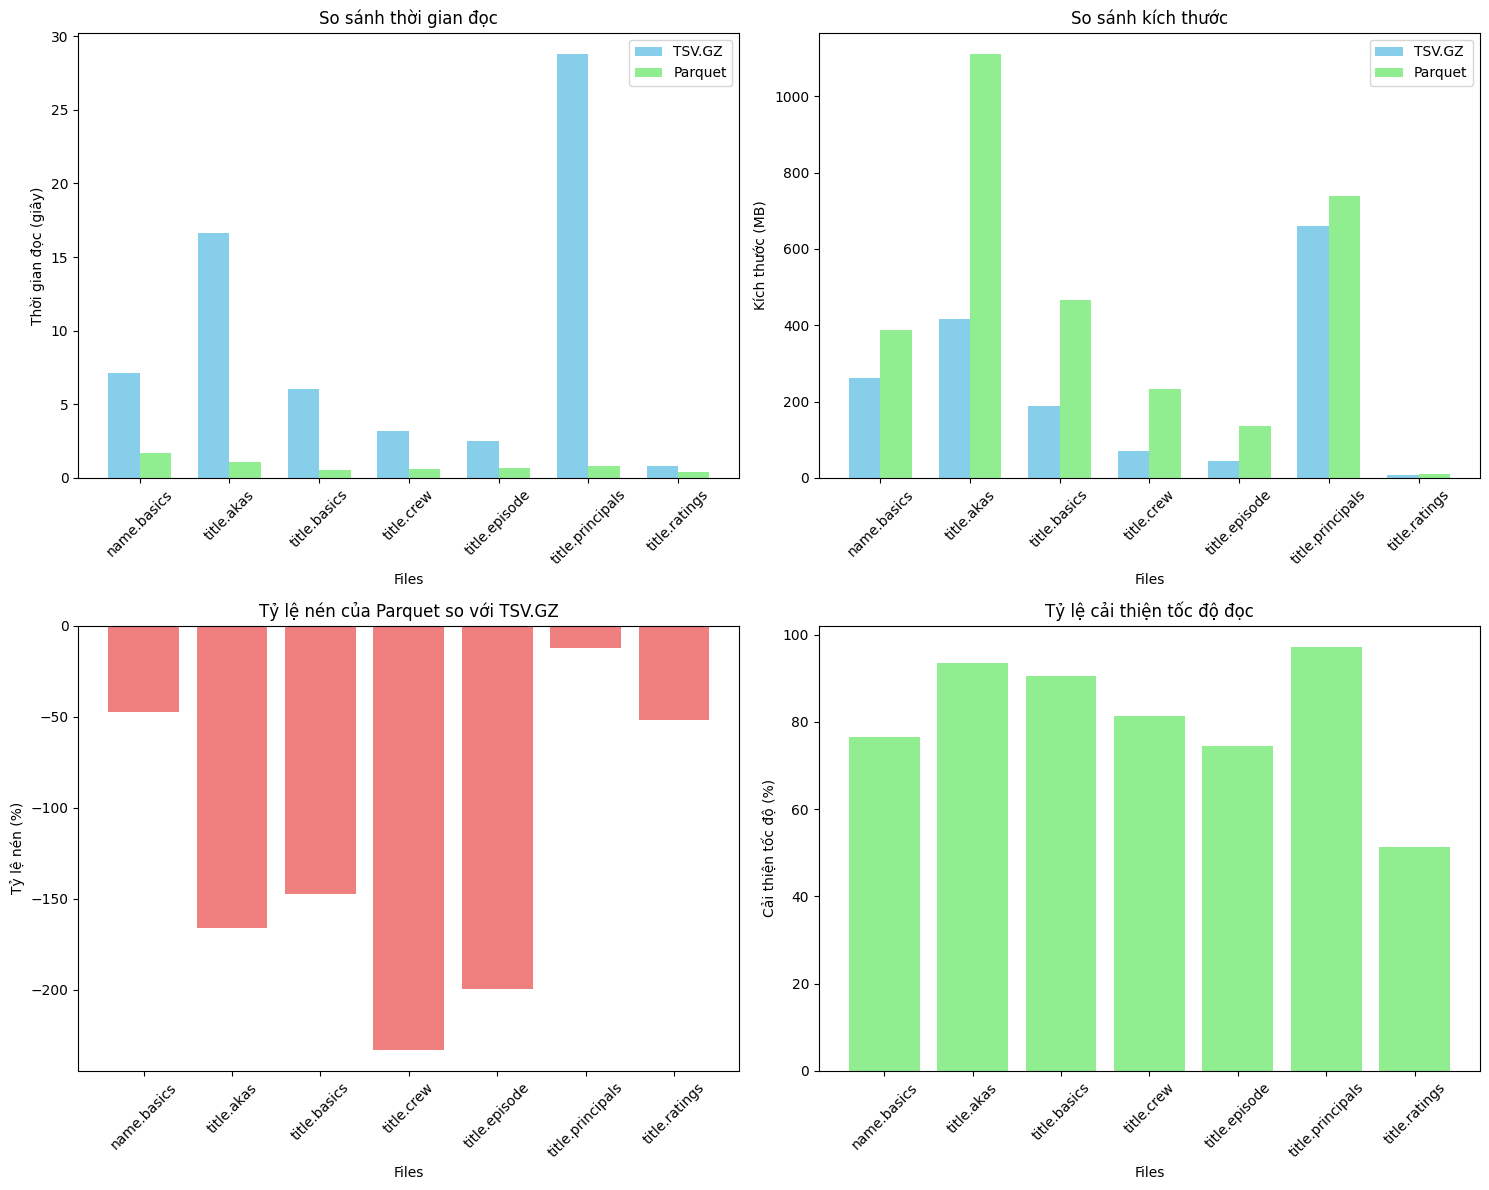

In [20]:
read_speed_files(files)


Đang xử lý: title.akas
Kích thước TSV.GZ: 417.38 MB
Kích thước Parquet: 1.08 GB
Đang thử đọc file: /hadoop/data/title.akas.tsv.gz


Đọc thành công: 50586459 dòng
Đang thử đọc file: /hadoop/data/parquet/title_akas_parquet


Đọc thành công: 50586459 dòng

Kết quả chi tiết:
      file  tsv_time  parquet_time   speedup
title.akas 20.619005      2.845261 86.200784

Thống kê tổng hợp:
Thời gian trung bình đọc TSV.GZ: 20.62s
Thời gian trung bình đọc Parquet: 2.85s
Tỷ lệ cải thiện tốc độ trung bình: 86.20%
Tỷ lệ nén trung bình: -166.11%

File có cải thiện tốc độ nhiều nhất: title.akas (86.20%)
File có tỷ lệ nén tốt nhất: title.akas (-166.11%)


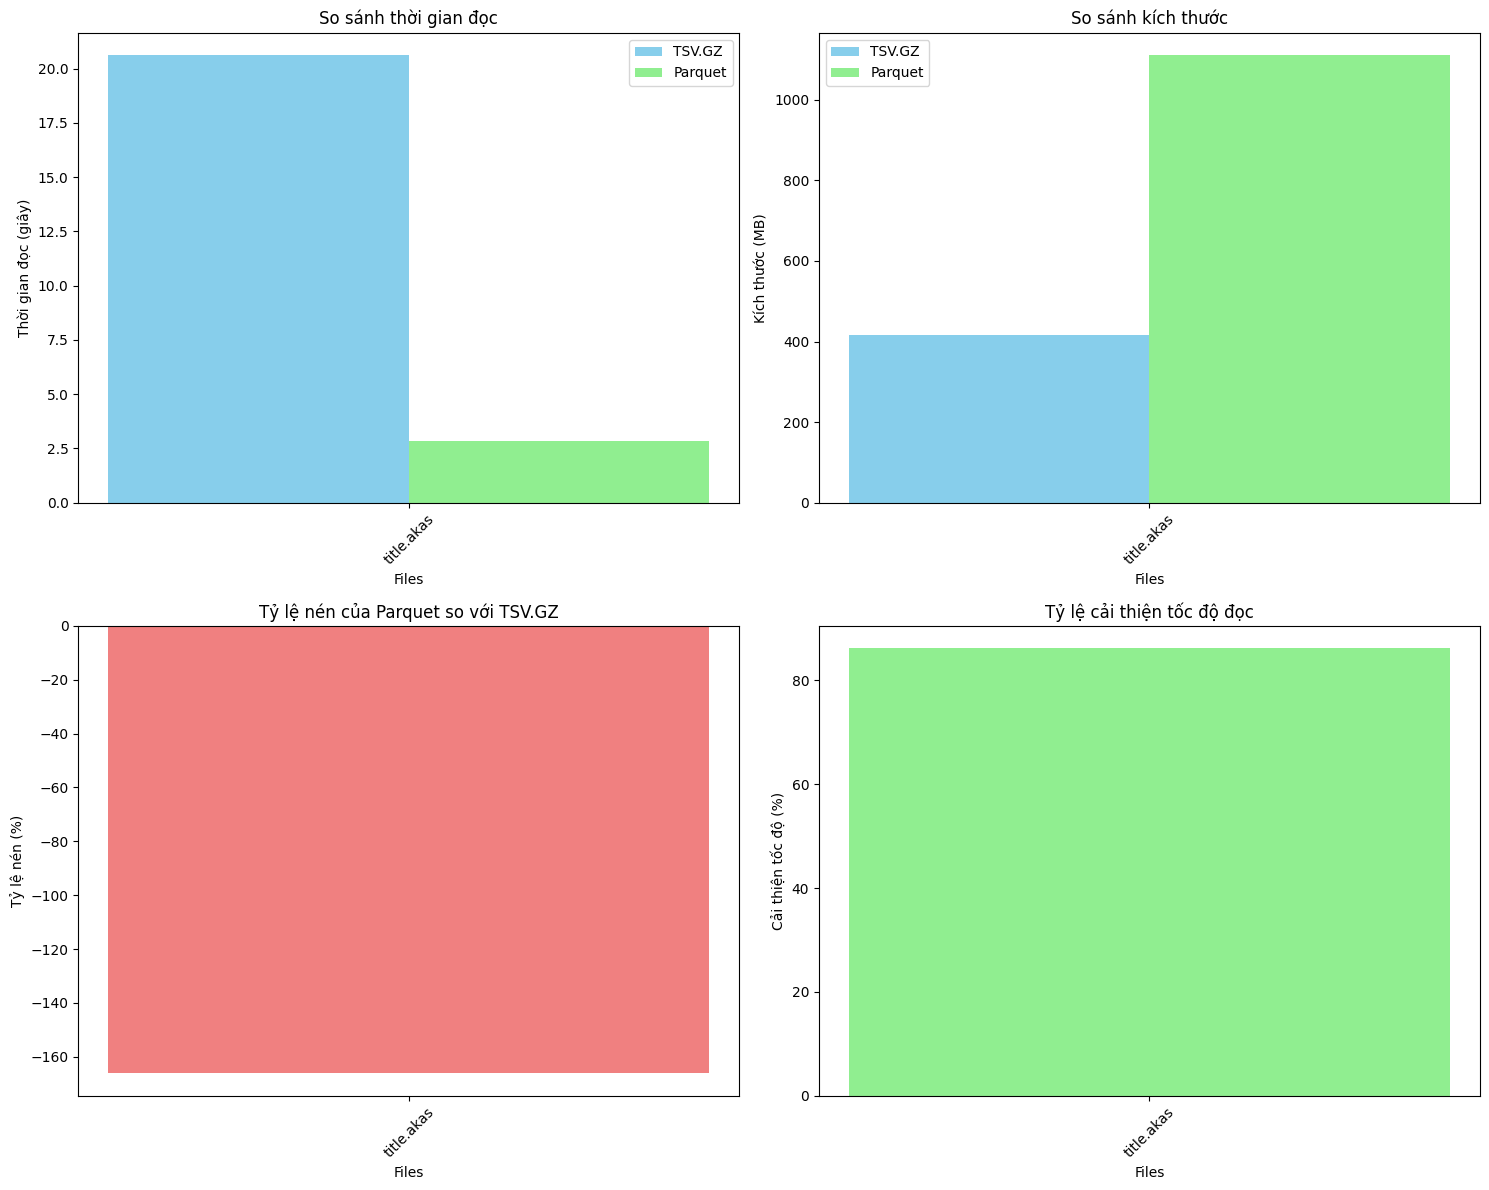

In [16]:
read_speed_file("title.akas")


Đang xử lý: title.basics
Kích thước TSV.GZ: 188.55 MB
Kích thước Parquet: 466.22 MB
Đang thử đọc file: /hadoop/data/title.basics.tsv.gz


Đọc thành công: 11253052 dòng
Đang thử đọc file: /hadoop/data/parquet/title_basics_parquet
Đọc thành công: 11253052 dòng

Kết quả chi tiết:
        file  tsv_time  parquet_time   speedup
title.basics  7.420728       0.76538 89.685913

Thống kê tổng hợp:
Thời gian trung bình đọc TSV.GZ: 7.42s
Thời gian trung bình đọc Parquet: 0.77s
Tỷ lệ cải thiện tốc độ trung bình: 89.69%
Tỷ lệ nén trung bình: -147.27%

File có cải thiện tốc độ nhiều nhất: title.basics (89.69%)
File có tỷ lệ nén tốt nhất: title.basics (-147.27%)


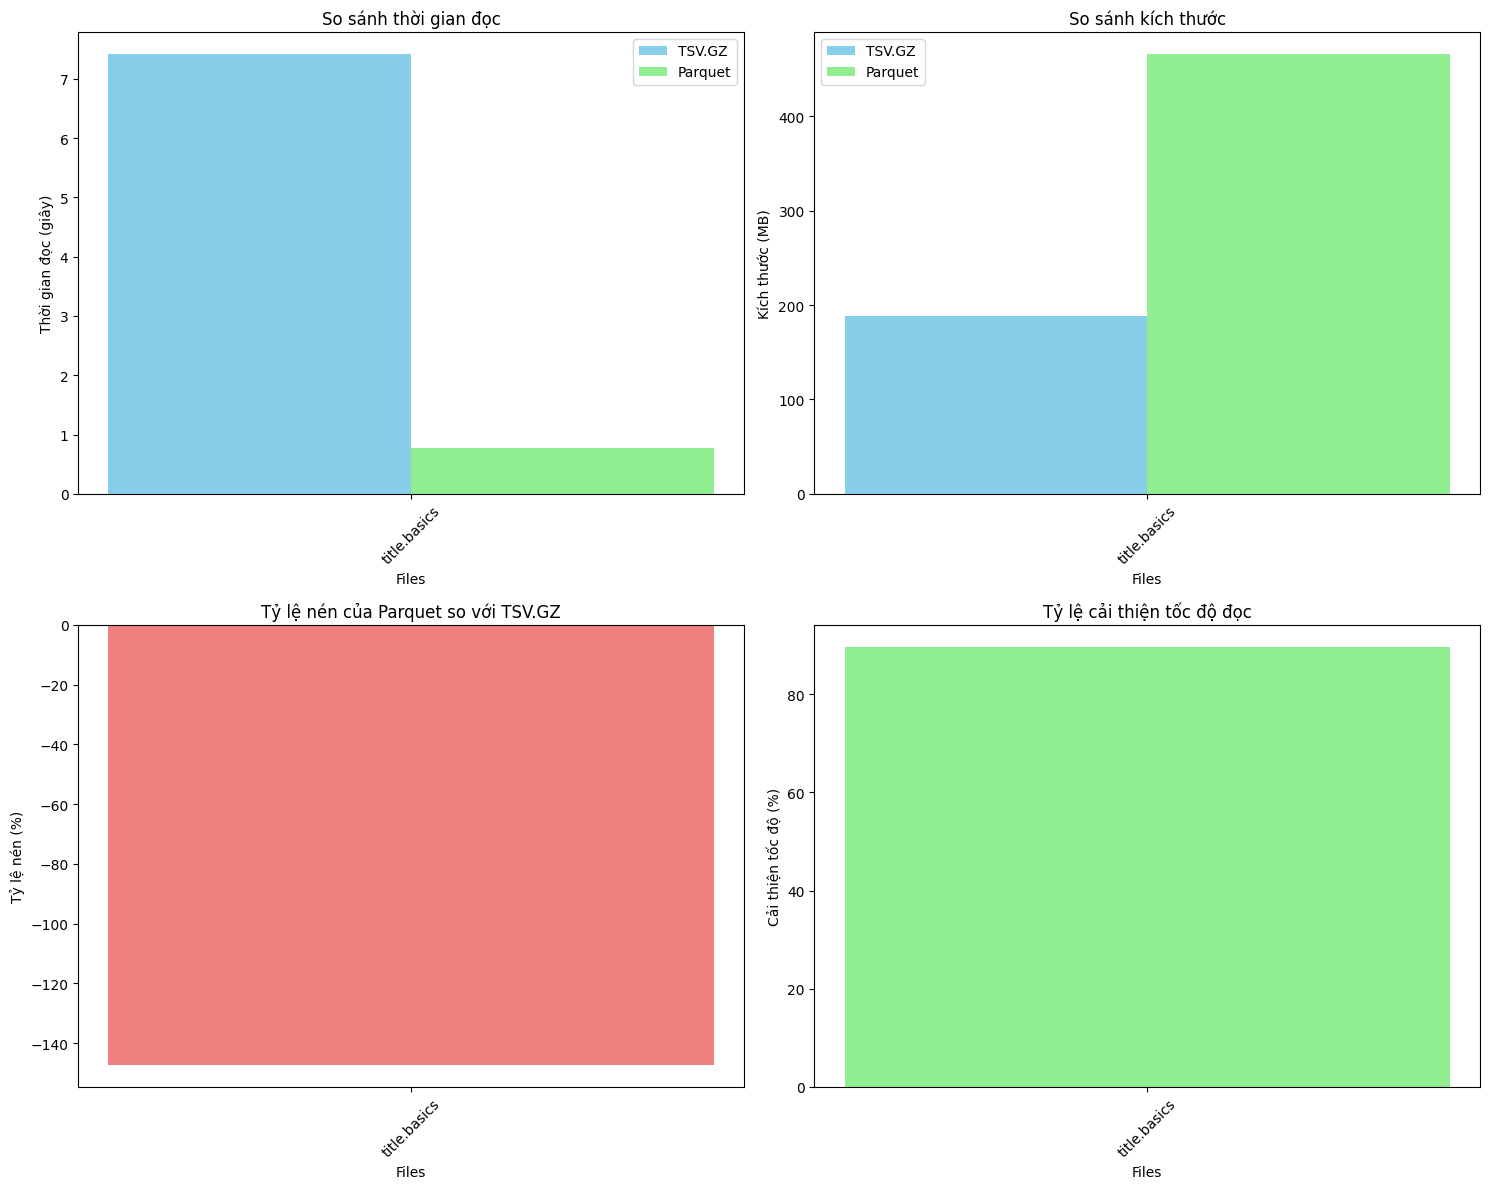

In [15]:
read_speed_file("title.basics")


Đang xử lý: name.basics
Kích thước TSV.GZ: 263.00 MB
Kích thước Parquet: 387.72 MB
Đang thử đọc file: /hadoop/data/name.basics.tsv.gz


Đọc thành công: 13966091 dòng
Đang thử đọc file: /hadoop/data/parquet/name_basics_parquet
Đọc thành công: 13966091 dòng

Kết quả chi tiết:
       file  tsv_time  parquet_time   speedup
name.basics  9.922176      0.841521 91.518785

Thống kê tổng hợp:
Thời gian trung bình đọc TSV.GZ: 9.92s
Thời gian trung bình đọc Parquet: 0.84s
Tỷ lệ cải thiện tốc độ trung bình: 91.52%
Tỷ lệ nén trung bình: -47.42%

File có cải thiện tốc độ nhiều nhất: name.basics (91.52%)
File có tỷ lệ nén tốt nhất: name.basics (-47.42%)


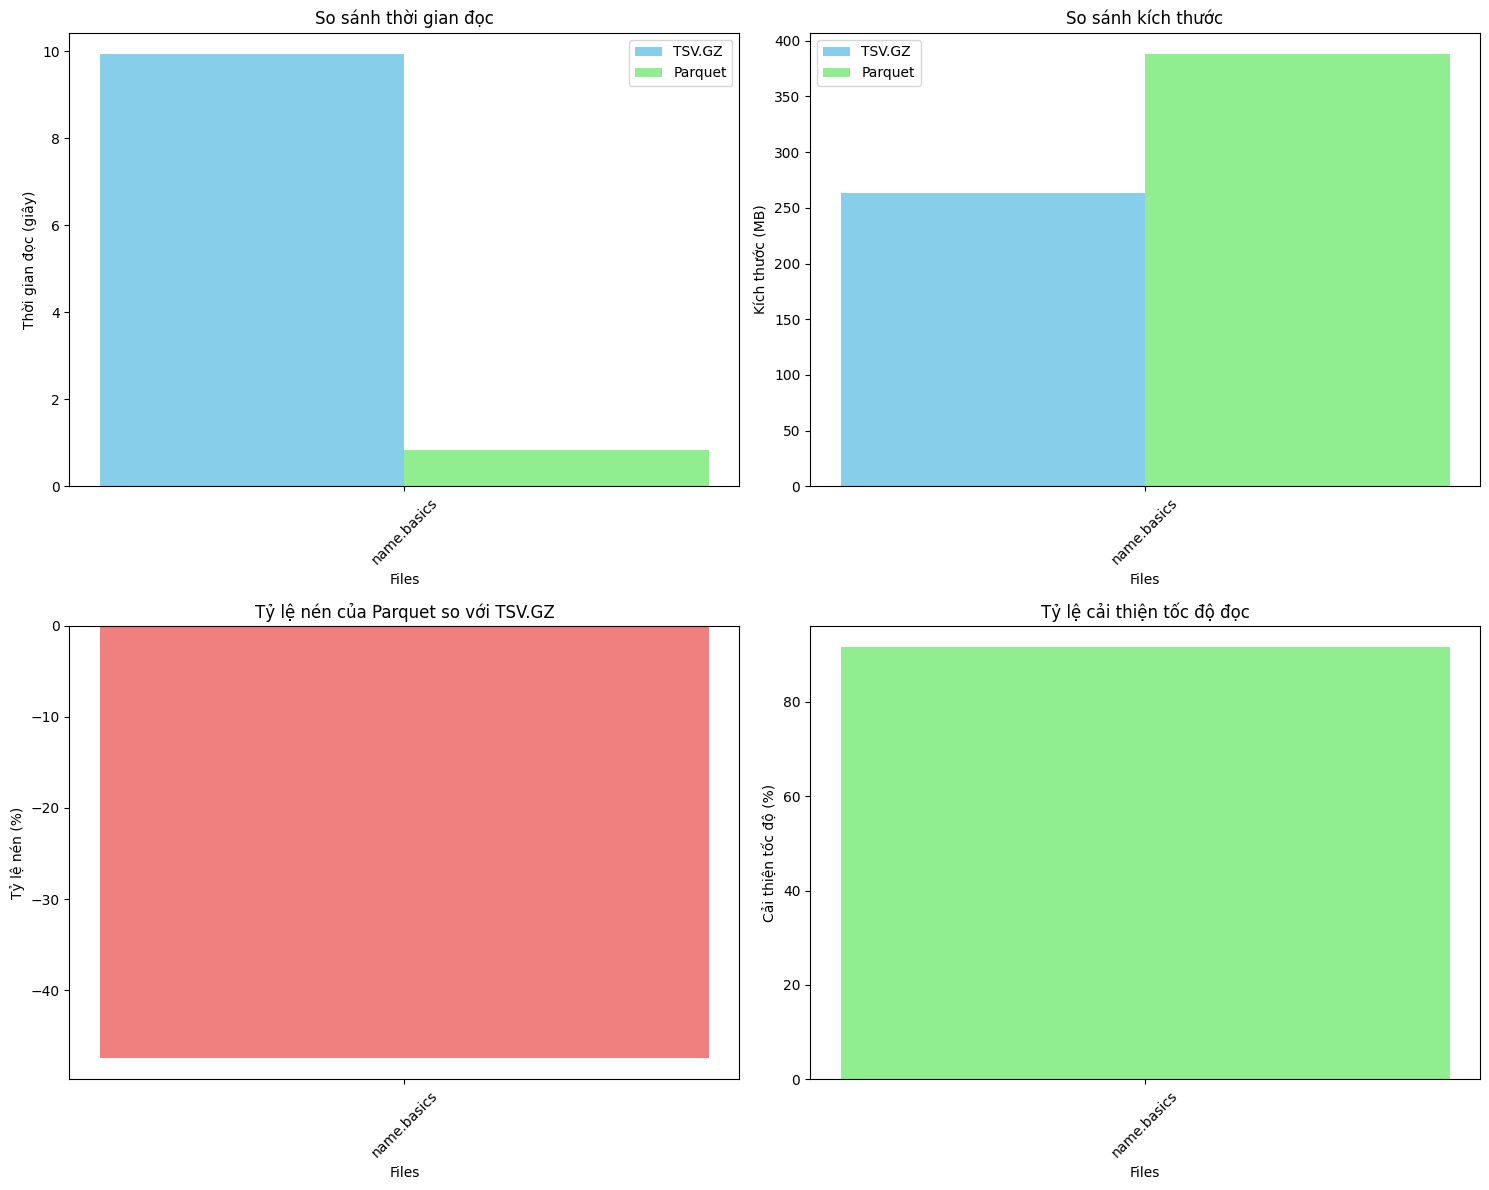

In [14]:
read_speed_file("name.basics")